# **4. 欧式期权二叉树模型定价过程概述**

#### 1. **定义输入参数**：
   - **当前资产价格** $ S_0 $：即期初的股票价格。
   - **执行价格** $ K $：期权的执行价格。
   - **到期时间** $ T $：期权的到期时间，以年为单位。
   - **无风险利率** $ r $：无风险利率，通常为政府债券的年利率。
   - **资产波动率** $ \sigma $：股票的年化波动率，反映股票价格的波动程度。
   - **时间步数** $ N $：期权定价模型中的时间离散步数。

#### 2. **计算每个时间步的步长** $ \Delta t $：
   $$
   \Delta t = \frac{T}{N}
   $$
   其中，$ T $ 是到期时间，$ N $ 是时间步数。


#### 3. **计算资产价格树**：
   - 计算每个时间步的资产价格，使用上升比例 $ u $ 和下降比例 $ d $。
   - 上升比例 $ u $ 和下降比例 $ d $ 由波动率 $ \sigma $ 和时间步长 $ \Delta t $ 计算得出：
     $$
     u = e^{\sigma \sqrt{\Delta t}}
     $$
     $$
     d = \frac{1}{u}
     $$
   - 资产价格树的末端节点计算公式：
     $$
     S_{i,j} = S_0 \cdot u^{i-j} \cdot d^j
     $$
     其中，$ i $ 是时间步数，$ j $ 是资产价格树中的节点位置，可以理解为在最后的节点，标的资产价格上升了 $i-j$ 次，下降了 $j$ 次。
     
     由此我们可以得到函数  ‘calculate_asset_price_tree’ ，他计算了所有树节点上标的资产可能出现的价格。

In [6]:
def calculate_asset_price_tree(S0, u, d, N):
    """
    计算资产价格树。
    
    参数：
    - S0: 当前资产价格
    - u: 上升比例
    - d: 下降比例
    - N: 时间步数
    
    返回：
    - 资产价格树
    """
    asset_price_tree = np.zeros((N+1, N+1))
    for i in range(N+1):
        for j in range(i+1):
            asset_price_tree[j, i] = S0 * (u ** (i-j)) * (d ** j)
    return asset_price_tree

#### 4. **计算期权价格树（末端节点）**：
   - 根据期权类型（看涨期权或看跌期权），在资产价格树的末端节点上计算期权的终值。
   - 对于看涨期权：
     $$
     C_{i,N} = \max(S_{i,N} - K, 0)
     $$
   - 对于看跌期权：
     $$
     P_{i,N} = \max(K - S_{i,N}, 0)
     $$
   - 其中，$ C $ 表示看涨期权价格，$ P $ 表示看跌期权价格。
  
   对于欧式期权来说，我们只会在二叉树的末端判断是否行权，因此我们可以得到函数 'calculate_option_tree'，他计算了二叉树末端所有节点的期权价值。

In [10]:
def calculate_option_tree(asset_price_tree, K, option_type, N):
    """
    计算期权价格树。
    
    参数：
    - asset_price_tree: 资产价格树
    - K: 执行价格
    - option_type: 期权类型 ("call" 或 "put")
    - N: 时间步数
    
    返回：
    - 期权价格树
    """
    option_tree = np.zeros((N+1, N+1))
    for i in range(N+1):
        if option_type == "call":
            option_tree[i, N] = max(asset_price_tree[i, N] - K, 0)
        elif option_type == "put":
            option_tree[i, N] = max(K - asset_price_tree[i, N], 0)
    return option_tree

#### 5. **根据期权定价的递推关系计算前一层节点的期权价格**：
   - 期权价格的递推公式：
     $$
     C_{i,j} = e^{-r \Delta t} \left( p \cdot C_{i,j+1} + (1 - p) \cdot C_{i+1,j+1} \right)
     $$
     $$
     P_{i,j} = e^{-r \Delta t} \left( p \cdot P_{i,j+1} + (1 - p) \cdot P_{i+1,j+1} \right)
     $$
     其中，$ p $ 是上升的概率，计算公式为：
     $$
     p = \frac{e^{r \Delta t} - d}{u - d}
     $$ 
   - 递推公式用于计算从末端到根节点的期权价格。

In [12]:
def backtrack_option_prices(option_tree, p, r, dt, N):
    """
    回溯期权价格，计算每个节点的期权价格。
    
    参数：
    - option_tree: 期权价格树
    - p: 上升的概率
    - r: 无风险利率
    - dt: 每个时间步的长度
    - N: 时间步数
    
    返回：
    - 回溯后的期权价格树
    """
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            option_tree[j, i] = np.exp(-r * dt) * (p * option_tree[j, i+1] + (1 - p) * option_tree[j+1, i+1])
    return option_tree

#### 6. **欧式期权二叉树模型整体估值流程**：
   
最后我们整合所有步骤，得到函数 'binomial_option_pricing'，他会返回根节点的欧式期权估值结果。

In [21]:
def binomial_option_pricing(S0, K, T, r, sigma, N, option_type="call"):
    """
    使用二叉树模型定价欧式期权并计算期权价格。
    
    参数：
    - S0: 当前资产价格
    - K: 执行价格
    - T: 到期时间
    - r: 无风险利率
    - sigma: 资产波动率
    - N: 时间步数
    - option_type: 期权类型 ("call" 或 "put")
    
    返回：
    - 欧式期权的定价
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # 计算资产价格树
    asset_price_tree = calculate_asset_price_tree(S0, u, d, N)
    
    # 计算期权价格树
    option_tree = calculate_option_tree(asset_price_tree, K, option_type, N)
    
    # 回溯期权价格
    option_tree = backtrack_option_prices(option_tree, p, r, dt, N)
    
    # 返回期权价格
    return option_tree[0, 0]

In [22]:
import numpy as np

# 示例使用
S0 = 100    # 当前资产价格
K = 100     # 执行价格
T = 1       # 到期时间1年
r = 0.05    # 无风险利率5%
sigma = 0.2 # 波动率20%
N = 5       # 时间步数

call_price = binomial_option_pricing(S0, K, T, r, sigma, N, option_type="call")
print(f"欧式看涨期权的价格: {call_price:.2f}")

欧式看涨期权的价格: 10.81


#### 7. **欧式期权二叉树模型的收敛情况**：

我们设定期权价格的理论值为 10.4506，这是第二章相同参数下BS模型的解析解，令时间步长从 50 到 1000，间隔为50。
   

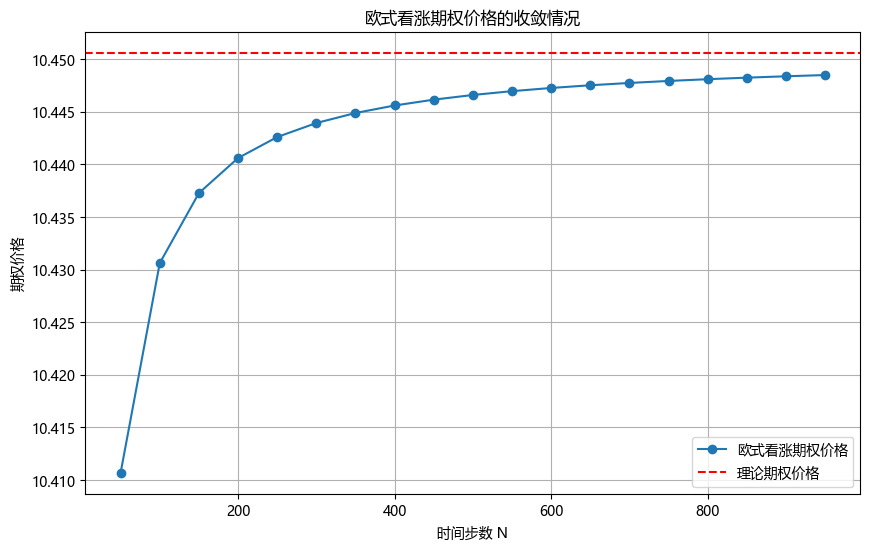

In [34]:
import matplotlib.pyplot as plt
import matplotlib

# 设置中文字体
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei']
matplotlib.rcParams['axes.unicode_minus'] = False

# 期权价格的理论值（可以通过其他方法获得）
theoretical_price = 10.4506

# 存储不同N对应的期权价格
N_values = np.arange(50, 1000, 50)
call_prices = []

# 计算不同步长下的期权价格
for N in N_values:
    call_price = binomial_option_pricing(S0, K, T, r, sigma, N, option_type="call")
    call_prices.append(call_price)

# 绘制期权价格收敛图形
plt.figure(figsize=(10, 6))
plt.plot(N_values, call_prices, label="欧式看涨期权价格", marker='o')
plt.axhline(y=theoretical_price, color='r', linestyle='--', label="理论期权价格")
plt.xlabel("时间步数 N")
plt.ylabel("期权价格")
plt.title("欧式看涨期权价格的收敛情况")
plt.legend()
plt.grid(True)
plt.show()